In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [7]:
import skimage 
from skimage import io, filters

In [9]:
fname = "/Users/timrudge/RaspiScope/timelapse/timlap_3_%04d.jpg"
fname%(10)

'/Users/timrudge/RaspiScope/timelapse/timlap_3_0010.jpg'

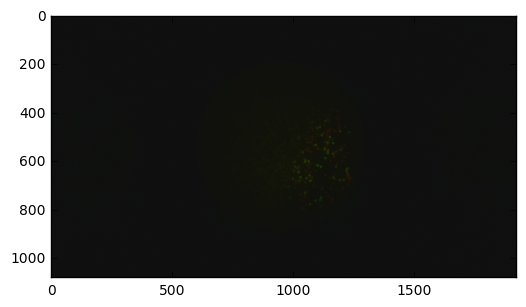

In [11]:
im = io.imread(fname%0)
plt.imshow(im)

In [14]:
im.shape

(1080, 1920, 3)

In [110]:
nt = 139
ims = np.zeros((1080,1920,nt))
for i in range(nt):
    im = plt.imread(fname%i)
    ims[:,:,i] = im[:,:,1]

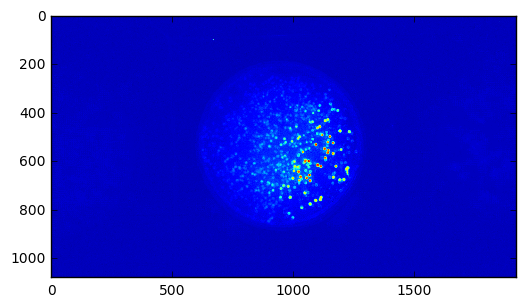

In [111]:
plt.imshow(ims[:,:,-1])

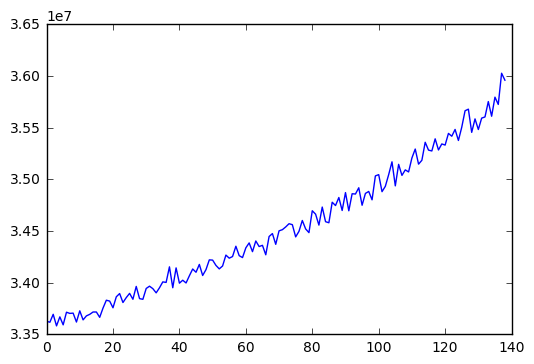

In [153]:
plt.plot(ims.sum(axis=(0,1)))

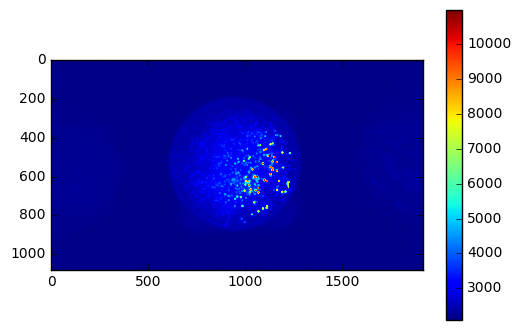

In [113]:
ims_sum = ims.sum(axis=2)
plt.imshow(ims_sum)
plt.colorbar()

In [114]:
from skimage.filters import gaussian
sim = gaussian(ims_sum, 1.5)
nsim = (sim-sim.min())/(sim.max()-sim.min())

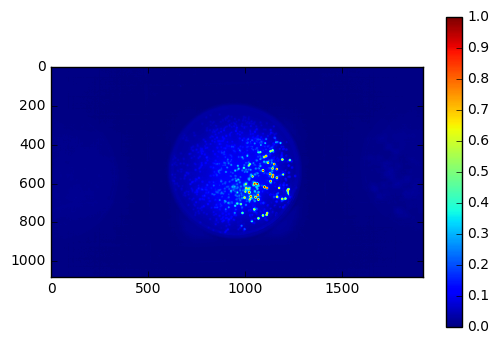

In [115]:
plt.imshow(nsim)
plt.colorbar()

In [159]:
import skimage.feature as skfeat
A = skfeat.blob_log(nsim, min_sigma=1, max_sigma=10, num_sigma=10, threshold=0.02, overlap=0.8)

In [161]:
A.shape
#A[1:10,:]

(333, 3)

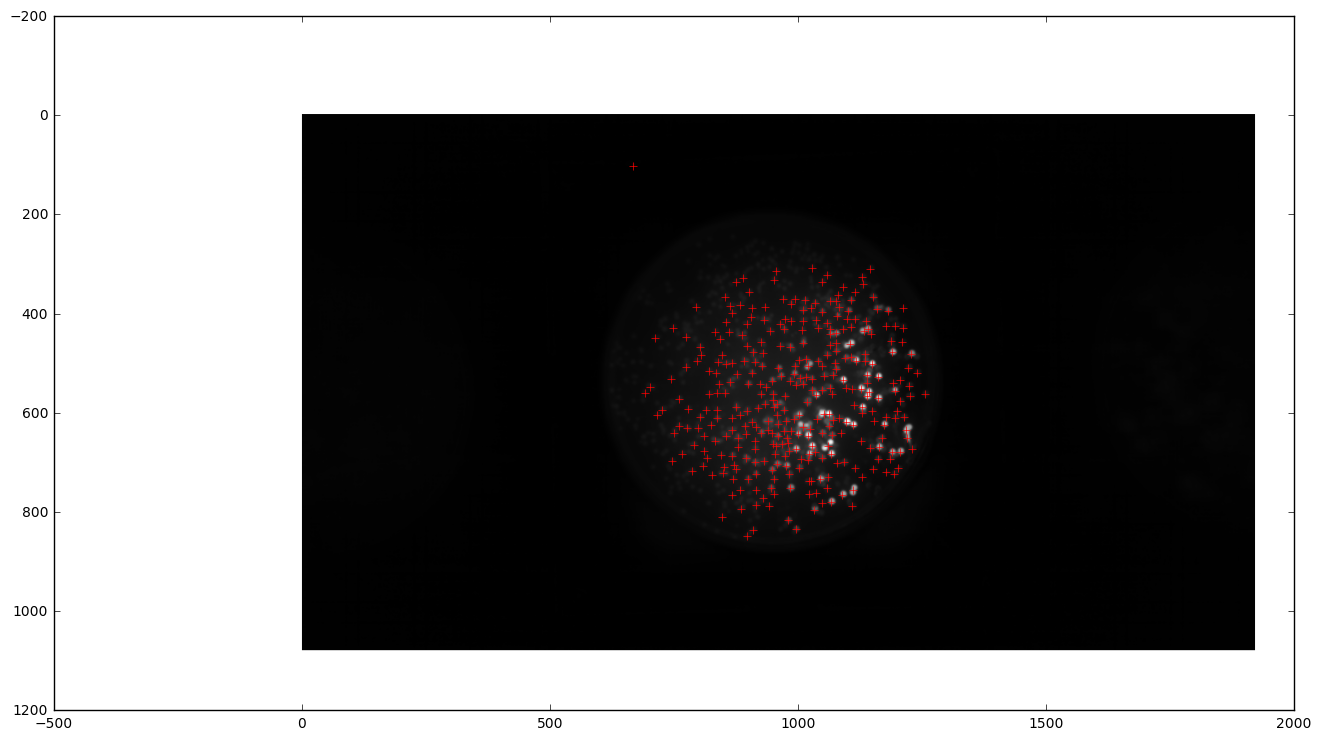

In [162]:
plt.figure(figsize=(16,12))
plt.imshow(nsim, cmap='gray')
plt.hold(True)
for i in range(len(A)):
    plt.plot(A[i,1],A[i,0],'r+')

/Users/timrudge/miniconda/envs/raspiscope/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


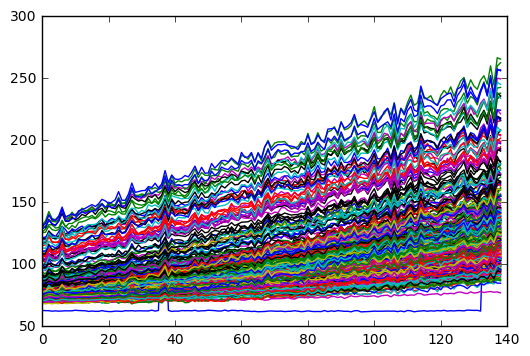

In [167]:
for i in range(len(A)):
    x = A[i,0]
    y = A[i,1]
    r = 2*A[i,2]
    roi = ims[x-r:x+r,y-r:y+r,:]/(r*r)
    plt.plot(roi.sum(axis=(0,1)))
    plt.hold(True)
plt.legend()

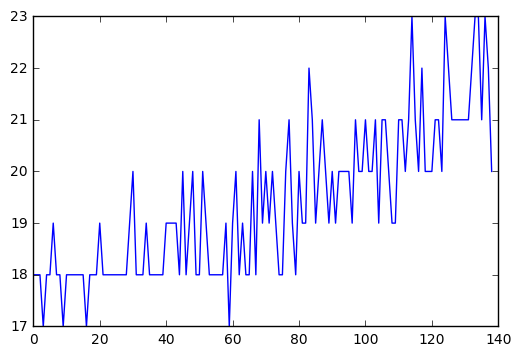

In [88]:
plt.plot(ims[677,1110,:])

/Users/timrudge/miniconda/envs/raspiscope/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':
/Users/timrudge/miniconda/envs/raspiscope/lib/python2.7/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


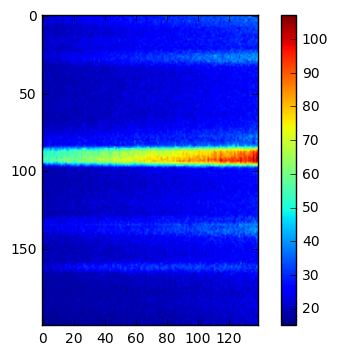

In [156]:
s = np.diff(ims[A[10,0],:,:], axis=1)
s.shape
plt.imshow(ims[A[10,0],1000:1200,:])
plt.colorbar()

/Users/timrudge/miniconda/envs/raspiscope/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/timrudge/miniconda/envs/raspiscope/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


18.035544271659791

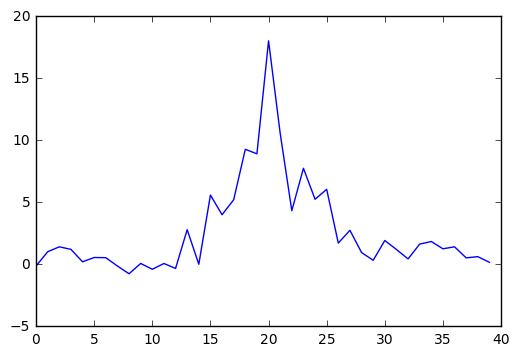

In [150]:
c=np.cov(s)
x = A[10,0]
y = A[10,1]
plt.plot(c[y,y-20:y+20])
c[y,y]